# SMS Spam Detection — Full Project Notebook

**What this notebook contains (end-to-end):**

- Download the SMS Spam Collection dataset (UCI)
- Data loading and exploratory data analysis (EDA)
- Text preprocessing (cleaning, tokenization, lemmatization)
- Feature engineering (TF-IDF; optional Word2Vec mention)
- Train **three** models: MultinomialNB, Logistic Regression, and an LSTM
- Evaluate models with precision, recall, F1, confusion matrix
- Save trained models and tokenizer
- Notes on packaging / demo (Streamlit)

> This notebook is written so you can run it in Google Colab or local Jupyter. If running locally, ensure required packages are installed (see the first code cell).


In [ ]:
# %%bash
# (Uncomment and run if packages missing)
%pip install -q numpy pandas scikit-learn nltk gensim matplotlib seaborn tensorflow joblib streamlit





Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import os
import re
import zipfile
import random
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import joblib

# Keras / TensorFlow for LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# NLTK for preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
# Dataset download
# The classic SMS Spam Collection is available from UCI. This notebook assumes you will run it in Colab
# where internet access is allowed. The URL below should work in Colab / local with internet.
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

zip_path = DATA_DIR / "smsspamcollection.zip"
txt_path = DATA_DIR / "SMSSpamCollection"

if not txt_path.exists():
    try:
        import requests
        print("Downloading dataset...")
        r = requests.get(DATA_URL, stream=True)
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        # extract
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(DATA_DIR)
        print("Downloaded and extracted dataset to", txt_path)
    except Exception as e:
        print("Could not download automatically. Please manually download the 'SMSSpamCollection' file from:")
        print(DATA_URL)
        print("Then place it inside the 'data' folder.")
else:
    print("Dataset already present at", txt_path)

# Load into DataFrame
if txt_path.exists():
    df = pd.read_csv(txt_path, sep='\t', header=None, names=['label', 'message'], encoding='latin-1')
    print("Loaded dataset, shape:", df.shape)
    display(df.head())
else:
    print("Dataset file not found. Please download from the URL above and place SMSSpamCollection into ./data/")


Downloaded and extracted dataset to data\SMSSpamCollection
Loaded dataset, shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Class distribution:


label
ham     4825
spam     747
Name: count, dtype: int64

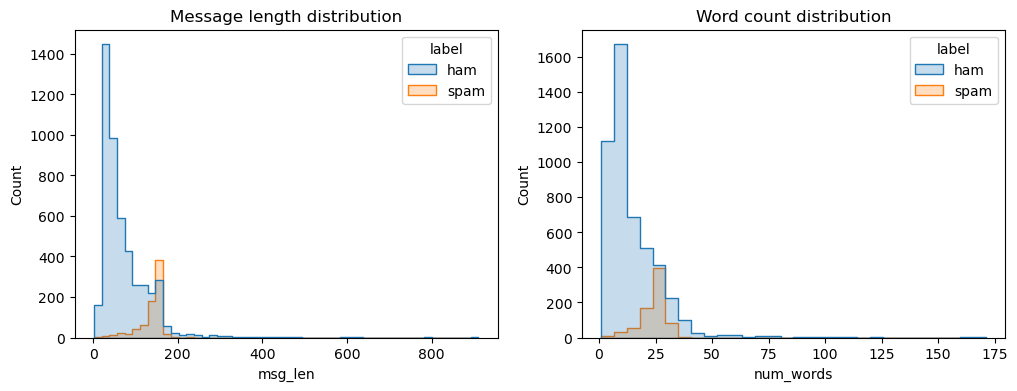


Sample HAM messages:


["If i not meeting Ã¼ all rite then i'll go home lor. If Ã¼ dun feel like comin it's ok.",
 'I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.',
 'Sorry that took so long, omw now',
 'I thk 50 shd be ok he said plus minus 10.. Did Ã¼ leave a line in between paragraphs?',
 "Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one Ã¼ cut ur hair. "]


Sample SPAM messages:


['Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804',
 'This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate ',
 'Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just Â£1.50 per wk 2 opt out send STOP 08452810071 16',
 'Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send GO to 86688 only 150p/msg. CC: 08718720201 PO BOX 114/14 TCR/W1',
 'Last Chance! Claim ur Â£150 worth of discount vouchers today! Text SHOP to 85023 now! SavaMob, offers mobile! T Cs SavaMob POBOX84, M263UZ. Â£3.00 Sub. 16']

In [6]:
# Exploratory Data Analysis (EDA)
print("Class distribution:")
display(df['label'].value_counts())

# Convert label to numeric for convenience
df['label_num'] = df['label'].map({'ham':0, 'spam':1})

# Message length features
df['msg_len'] = df['message'].apply(len)
df['num_words'] = df['message'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df, x='msg_len', hue='label', bins=50, element='step')
plt.title('Message length distribution')

plt.subplot(1,2,2)
sns.histplot(df, x='num_words', hue='label', bins=30, element='step')
plt.title('Word count distribution')
plt.show()

# Show some spam and ham examples
print('\nSample HAM messages:')
display(df[df['label']=='ham'].sample(5, random_state=42)['message'].tolist())
print('\nSample SPAM messages:')
display(df[df['label']=='spam'].sample(5, random_state=42)['message'].tolist())


In [7]:
# Preprocessing: cleaning, tokenization, lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)   # remove urls
    text = re.sub(r'[^a-z0-9\s]', ' ', text)      # keep alphanumerics
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply preprocessing and save cleaned text
df['cleaned'] = df['message'].apply(clean_text).apply(tokenize_and_lemmatize)
display(df[['label','message','cleaned']].head())


,label,message,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [8]:
# Train/validation/test split (stratified)
X = df['cleaned']
y = df['label_num']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (3900,) Val: (836,) Test: (836,)


In [9]:
# Model 1: Multinomial Naive Bayes with TF-IDF
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=2)),
    ('clf', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred_val_nb = pipeline_nb.predict(X_val)
print("Validation classification report (Naive Bayes):")
print(classification_report(y_val, y_pred_val_nb))

# Save model
Path('models').mkdir(exist_ok=True)
joblib.dump(pipeline_nb, 'models/nb_spam_model.joblib')
print('Saved NB model to models/nb_spam_model.joblib')


Validation classification report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.74      0.85       112

    accuracy                           0.97       836
   macro avg       0.98      0.87      0.92       836
weighted avg       0.97      0.97      0.96       836

Saved NB model to models/nb_spam_model.joblib


In [10]:
# Model 2: Logistic Regression with TF-IDF (n-grams)
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=2)),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)
y_pred_val_lr = pipeline_lr.predict(X_val)
print("Validation classification report (Logistic Regression):")
print(classification_report(y_val, y_pred_val_lr))

joblib.dump(pipeline_lr, 'models/lr_spam_model.joblib')
print('Saved LR model to models/lr_spam_model.joblib')

# Show top positive/negative coefficients for LR
tfidf = pipeline_lr.named_steps['tfidf']
clf = pipeline_lr.named_steps['clf']
feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]
top_pos = np.argsort(coefs)[-20:][::-1]
top_neg = np.argsort(coefs)[:20]

print('\nTop spam-indicative ngrams:')
for i in top_pos[:20]:
    print(feature_names[i], coefs[i])
print('\nTop ham-indicative ngrams:')
for i in top_neg[:20]:
    print(feature_names[i], coefs[i])


Validation classification report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       724
           1       0.99      0.77      0.86       112

    accuracy                           0.97       836
   macro avg       0.98      0.88      0.92       836
weighted avg       0.97      0.97      0.97       836

Saved LR model to models/lr_spam_model.joblib

Top spam-indicative ngrams:
txt 4.203276828614507
mobile 3.3524599762720295
free 3.2287891171894905
claim 3.2069564500935166
stop 3.113564504041248
reply 3.110595792342599
call 3.003220791729446
service 2.7543800628382167
prize 2.5714526531745023
tone 2.434166769019962
150p 2.398329028655873
text 2.3954454925956274
uk 2.362409840405596
win 2.159059627183142
50 2.130716180784951
cash 1.9587188025058673
new 1.9525031403499966
urgent 1.949794887994392
18 1.9082103812694131
min 1.7795097288394566

Top ham-indicative ngrams:
ok -1.7676280472199526
home -1.3929590994653

In [11]:
# Model 3: Simple LSTM model
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, truncating='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_LEN, truncating='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, truncating='post')

# Save tokenizer
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

model = Sequential([
    Embedding(MAX_VOCAB, 64, input_length=MAX_LEN),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=6, batch_size=64)

# Save model
model.save('models/lstm_spam_model.h5')
print('Saved LSTM model to models/lstm_spam_model.h5')


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 321ms/step - accuracy: 0.8833 - loss: 0.3151 - val_accuracy: 0.9617 - val_loss: 0.1777
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.9754 - loss: 0.0958 - val_accuracy: 0.9797 - val_loss: 0.0634
Epoch 3/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.9910 - loss: 0.0354 - val_accuracy: 0.9856 - val_loss: 0.0517
Epoch 4/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9962 - loss: 0.0194 - val_accuracy: 0.9856 - val_loss: 0.0495
Epoch 5/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.9972 - loss: 0.0103 - val_accuracy: 0.9868 - val_loss: 0.0529
Epoch 6/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9985 - loss: 0.0083 - val_accuracy: 0.9856 - val_loss: 0.0500


Saved LSTM model to models/lstm_spam_model.h5


Naive Bayes Test Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       724
           1       1.00      0.79      0.89       112

    accuracy                           0.97       836
   macro avg       0.98      0.90      0.93       836
weighted avg       0.97      0.97      0.97       836



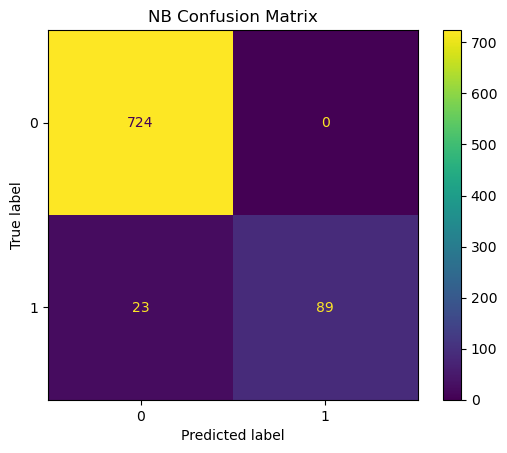

Logistic Regression Test Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       724
           1       1.00      0.77      0.87       112

    accuracy                           0.97       836
   macro avg       0.98      0.88      0.93       836
weighted avg       0.97      0.97      0.97       836



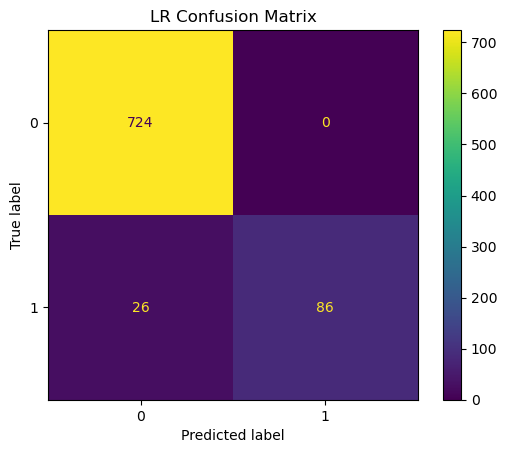

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
LSTM Test Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.93      0.95       112

    accuracy                           0.99       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



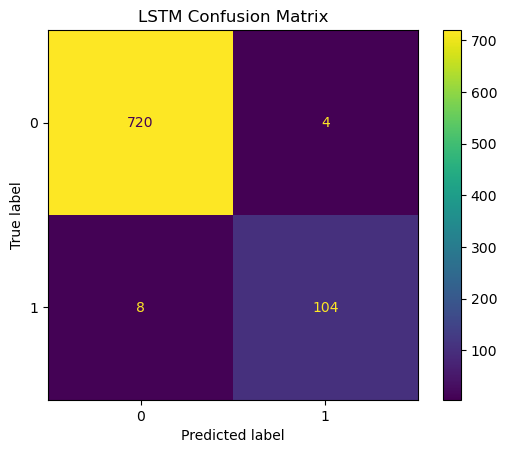

,accuracy,precision,recall,f1
model,,,,
NaiveBayes,0.972488,1.000000,0.794643,0.885572
LogisticRegression,0.968900,1.000000,0.767857,0.868687
LSTM,0.985646,0.962963,0.928571,0.945455


In [12]:
# Final evaluation on test set
from sklearn.metrics import ConfusionMatrixDisplay

# NB
y_test_pred_nb = pipeline_nb.predict(X_test)
print("Naive Bayes Test Report")
print(classification_report(y_test, y_test_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_nb)
plt.title('NB Confusion Matrix')
plt.show()

# LR
y_test_pred_lr = pipeline_lr.predict(X_test)
print("Logistic Regression Test Report")
print(classification_report(y_test, y_test_pred_lr))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_lr)
plt.title('LR Confusion Matrix')
plt.show()

# LSTM
y_test_pred_lstm_prob = model.predict(X_test_seq).ravel()
y_test_pred_lstm = (y_test_pred_lstm_prob > 0.5).astype(int)
print("LSTM Test Report")
print(classification_report(y_test, y_test_pred_lstm))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_lstm)
plt.title('LSTM Confusion Matrix')
plt.show()

# Summary table
def summarize_results(y_true, preds, name):
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    return {
        'model': name,
        'accuracy': accuracy_score(y_true, preds),
        'precision': precision_score(y_true, preds),
        'recall': recall_score(y_true, preds),
        'f1': f1_score(y_true, preds)
    }

summary = [
    summarize_results(y_test, y_test_pred_nb, 'NaiveBayes'),
    summarize_results(y_test, y_test_pred_lr, 'LogisticRegression'),
    summarize_results(y_test, y_test_pred_lstm, 'LSTM')
]
pd.DataFrame(summary).set_index('model')


# Conclusion and Next Steps

**What we did:** implemented three models for SMS spam detection (Naive Bayes, Logistic Regression, and LSTM), evaluated them on a held-out test set, and saved model artifacts for a demo.

**Next steps / improvements to get even better results (good to mention in report / video):**
- Try pretrained transformer models (e.g., DistilBERT) — they often outperform small LSTMs on limited text data.
- Data augmentation or combining multiple spam datasets for more coverage.
- Add handcrafted features (presence of URL, phone numbers, number of capital letters, punctuation emphasis, emoji counts).
- Use cross-validation and more careful hyperparameter tuning (GridSearchCV / RandomizedSearchCV).
- Add explainability (LIME / SHAP) to explain neural model predictions in the demo.

Good luck — if you want, I can also:
- create the Streamlit `app.py` file and a `requirements.txt`,
- push the whole project to a GitHub repo template,
- or record an example video script tailored to this notebook.